<a href="https://colab.research.google.com/github/lisahqwang/ML-DL-CV/blob/main/Hackathon_Data_Loading_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import Counter
from datetime import datetime
from itertools import chain
from pprint import pprint

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
# If this cell crashes due to OOM, just retry.

binary_questions = pd.read_json(
    "/content/gdrive/MyDrive/Million Predictions Hackathon/questions-binary-hackathon.json",
    orient="records",
    convert_dates=False, # This is necessary, otherwise Pandas messes up date conversion.
)
continuous_questions = pd.read_json(
    "/content/gdrive/MyDrive/Million Predictions Hackathon/questions-continuous-hackathon.json",
    orient="records",
    convert_dates=False, # This is necessary, otherwise Pandas messes up date conversion.
)
binary_predictions = pd.read_json(
    "/content/gdrive/MyDrive/Million Predictions Hackathon/predictions-binary-hackathon.json",
    orient="records",
)
continuous_predictions = pd.read_parquet( # We use parquet here for memory reasons. Locally, use JSON
    "/content/gdrive/MyDrive/Million Predictions Hackathon/predictions-continuous-hackathon.parquet",
)

ValueError: ignored

In [ ]:
# Convert prediction binary prediction timestamps to datetimes
binary_predictions["t"] = binary_predictions["t"].apply(datetime.fromtimestamp)

Text(0.5, 1.0, 'On 2021-12-31, will the FiveThirtyEight average of polls indicate that Joe Biden has a higher approval than disapproval rating?')

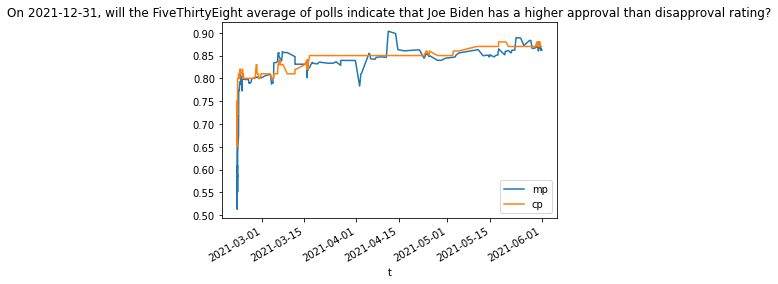

In [ ]:
# Plot the history of the community and metaculus predictions for a binary question
binary_predictions = binary_predictions.set_index("t", drop=False)
binary_predictions[binary_predictions["question_id"] == 6635].mp.plot(label="mp")
binary_predictions[binary_predictions["question_id"] == 6635].cp.plot(label="cp")
plt.legend()
plt.title(binary_questions[binary_questions["question_id"] == 6635].title.item())

Text(0.5, 1.0, 'CDF for user 124280 on question \n "Drake\'s Equation 3rd parameter n_e: What is the average number of habitable planets per star?"')

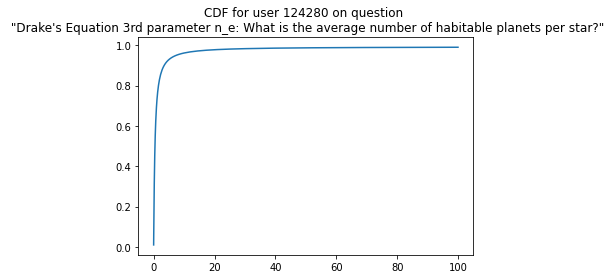

In [ ]:
# Plot the cdf of a user's prediction for a continuous prediction
row = continuous_predictions.iloc[1000]
question = continuous_questions[continuous_questions["question_id"] == row.question_id]
plt.plot(question.x_grid.item(), row.cdf)
plt.title(f"CDF for user {row.user_id} on question \n \"{question.title.item()}\"")

In [ ]:
# Inspect the most common question categories
continuous_categoreis = [category or [] for category in continuous_questions.categories.to_list()]
binary_categories = [category or [] for category in binary_questions.categories.to_list()]
all_categories = chain.from_iterable(binary_categories + continuous_categoreis)
pprint(Counter(all_categories).most_common(30))

[('Novel Coronavirus (Covid-19)', 479),
 ('Effective Altruism', 478),
 ('Politics – US', 409),
 ('Geopolitics – Armed Conflict', 359),
 ('Geopolitics', 297),
 ('Computer Science – AI and Machine Learning', 226),
 ('Economy – US', 180),
 ('Social issues', 166),
 ('Computing – Artificial Intelligence', 161),
 ('Politics – European', 161),
 ('Politics', 157),
 ('Technology – Space', 155),
 ('Biological Sciences – Medicine', 151),
 ('Industry – Space', 151),
 ('Environment – Climate', 150),
 ('Economy – US – Economic Indicators', 150),
 ('Series – Nuclear Threats', 136),
 ('Ukraine', 133),
 ('Biology – Infectious Disease', 125),
 ('Business', 124),
 ('Economy', 122),
 ('Technological Advances', 115),
 ('Physical Sciences – Astrophysics and Cosmology ', 107),
 ('Series — Forecasting AI Progress', 100),
 ('Finance — Cryptocurrencies', 99),
 ('Elections – U.S. – President', 96),
 ('Finance – markets', 94),
 ('Industry – Energy', 90),
 ('Global Epidemiology Cases', 83),
 ('Industry – Transport

In [ ]:
# Add data from questions table to predictions, and add useful time features
def augment_prediction_data(questions, predictions):
  questions = questions[questions.resolution_comment == "resolved"]
  questions["duration"] = questions.close_time - questions.publish_time
  question_data = questions[
      [
       "question_id",
       "resolution",
       "created_time",
       "publish_time",
       "close_time",
       "resolve_time",
       "duration",
      ]
  ]
  predictions = predictions.merge(question_data, on="question_id")
  predictions["t"] = predictions["t"].apply(lambda x: x.timestamp())
  predictions["time_to_resolution"] = predictions.resolve_time - predictions.t
  predictions["time_since_publish"] = predictions.t - predictions.publish_time
  predictions["relative_t"] = predictions.time_since_publish / predictions.duration
  return predictions

<ipython-input-7-c60fb4bb706b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions["duration"] = questions.close_time - questions.publish_time


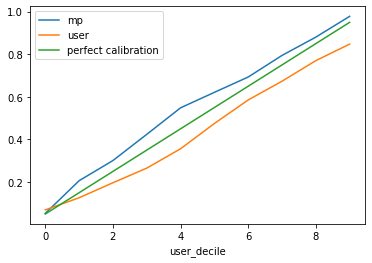

In [ ]:
# Quick-and-dirty calibration plot
predictions = augment_prediction_data(binary_questions, binary_predictions)
predictions["mp_decile"] = (predictions.mp * 100) // 10
predictions["user_decile"] = (predictions.prediction * 100) // 10
predictions.groupby(by=["mp_decile"]).apply(lambda df: df.resolution.mean()).plot()
predictions.groupby(by=["user_decile"]).apply(lambda df: df.resolution.mean()).plot()
plt.plot([0, 9], [.05, .95])
plt.legend(["mp", "user", "perfect calibration"])
plt.show()

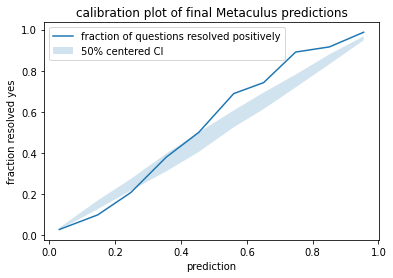

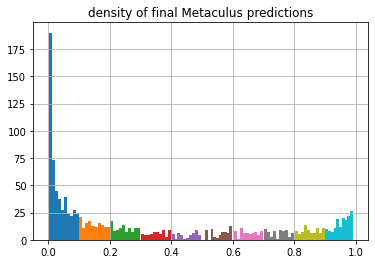

In [ ]:
# More sophisticated calibration plot
def bootstrap_outcome_quantiles(predictions, alpha=.1):
  """
  Treats `predictions` as real probabilities for independent events and
  samples them 10000 times to bootstrap alpha/2, 50%, and 1-alpha/2 quantiles 
  of the average outcome.
  """
  P = np.array(predictions)
  bootstrapped_outcomes = [np.mean((np.random.random(size=len(P)) < P).astype(float)) for i in range(10000)]
  return np.quantile(bootstrapped_outcomes, alpha)

alpha = .5
gdf = predictions.groupby("question_id").apply(
    lambda df: df.sort_values(by=['relative_t']).iloc[-1,:]
  ).groupby(by=["mp_decile"]) # get only the last prediction on each question and group by 'mp_decile'
decile_predictions = gdf.apply(lambda df: df.mp.mean())
decile_resolutions = gdf.apply(lambda df: df.resolution.mean())
decile_bootstrap_lower_bounds = gdf.apply(lambda df: bootstrap_outcome_quantiles(list(df.mp), alpha / 2))
decile_bootstrap_upper_bounds = gdf.apply(lambda df: bootstrap_outcome_quantiles(list(df.mp), 1 - alpha / 2))

plt.plot(decile_predictions, decile_resolutions)
plt.fill_between(decile_predictions, decile_bootstrap_lower_bounds, decile_bootstrap_upper_bounds, alpha=0.2)
plt.legend(["fraction of questions resolved positively",f"{int(100*(1-alpha))}% centered CI"])
plt.title("calibration plot of final Metaculus predictions")
plt.xlabel("prediction")
plt.ylabel("fraction resolved yes")
plt.show()
gdf.mp.hist()
plt.title("density of final Metaculus predictions")
plt.show()

In [ ]:
# Demo of aggregating binary forecasts
# NOTE: This will take forever to run in colab and will likely go OOM!!

def get_idxs_of_users_latest_forecasts(user_ids):
  latest_idxs = {}
  idxs_of_users_latest_forecasts = [0,]*len(user_ids)
  for i in range(len(user_ids)):
    latest_idxs[user_ids[i]] = i
    idxs_of_users_latest_forecasts[i] = [v for k, v in latest_idxs.items()]
  return idxs_of_users_latest_forecasts

def add_features_of_latest_forecasts(question_df):
  question_df = question_df.sort_values(by=['t'])
  idxs_of_users_latest_forecasts = get_idxs_of_users_latest_forecasts(list(question_df["user_id"]))
  features_of_latest_forecasts = [0,]*len(question_df.index)
  for i, idxs in enumerate(idxs_of_users_latest_forecasts):
    relevant_df = question_df.iloc[idxs]
    features_of_latest_forecasts[i] = {
      "predictions": list(relevant_df["prediction"]),
      "question_lifetime_portion_elapsed": list(relevant_df["relative_t"]),
      "reputations": list(relevant_df["reputation_at_t"]),
      "user_ids": list(relevant_df["user_id"])
    }
  question_df["features_of_latest_forecasts"] = features_of_latest_forecasts
  return question_df

predictions = predictions.groupby("question_id").apply(add_features_of_latest_forecasts).reset_index(drop=True)


def get_weighted_forecast(features_of_latest_forecasts, aggressiveness, relative_importance_of_reputation_vs_recency):
  predictions = np.array(features_of_latest_forecasts["predictions"])
  reputations = np.array(features_of_latest_forecasts["reputations"])
  relative_ts = np.array(features_of_latest_forecasts["question_lifetime_portion_elapsed"])
  s = relative_importance_of_reputation_vs_recency
  weight_logits = aggressiveness * (s * reputations + (1-s) * relative_ts)
  weight_logits -= max(weight_logits)
  weights = np.exp(weight_logits)
  weights = weights / np.sum(weights)
  return np.inner(weights, predictions)

def add_weighted_forecasts(df, aggressiveness, relative_importance_of_reputation_vs_recency):
  df["weighted_forecast"] = df.apply(
    lambda row:
      get_weighted_forecast(
          row.features_of_latest_forecasts, 
          aggressiveness, 
          relative_importance_of_reputation_vs_recency
      ), 
  axis=1)
  return df

add_weighted_forecasts(predictions, 1, .5)